# NEU-Regression: Simulation Experiments
---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

# Generate Training Data

In [1]:
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())

Using TensorFlow backend.
/scratch/users/kratsioa/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


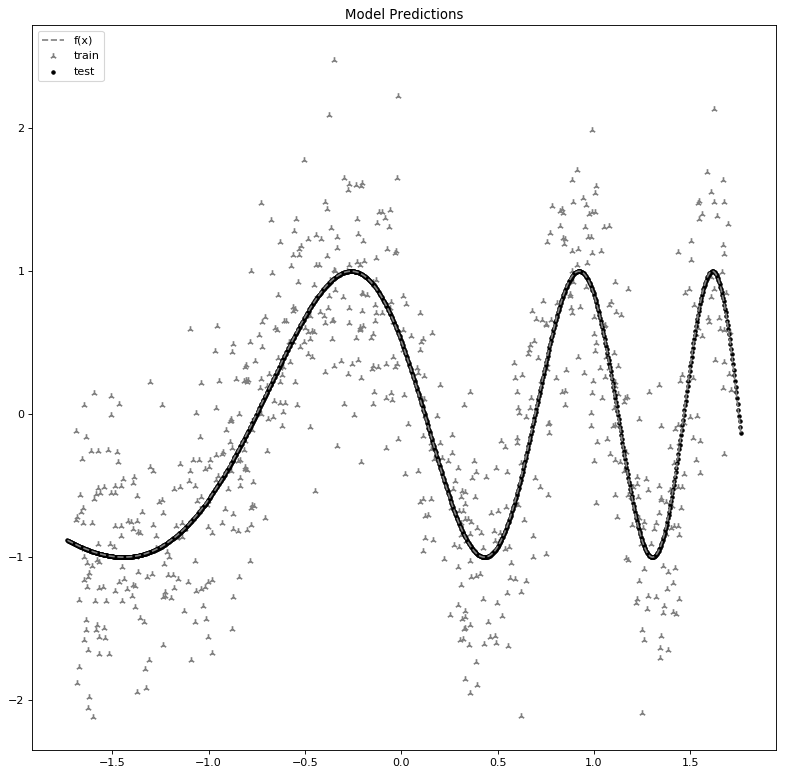

In [2]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
Option_Function = "oscilatory"
%run Data_Generator.ipynb

In [3]:
if d<= 1:
    # Backup data
    data_x_raw = data_x
    data_x_test_raw = data_x_test
    # Bump Dimension so Reconfiguration network properties hold
    data_x = np.concatenate([data_x,data_x**2],axis=1)
    data_x_test = np.concatenate([data_x_test,data_x_test**2],axis=1)
    d = d+1
    data_x_raw = data_x
else:
    # Backup data
    data_x_raw = data_x
    data_x_test_raw = data_x_test
    print(d)

## Initializations:
- Load Dependancies,
- Makes Paths if missing.

In [4]:
# Load Hyper( and meta) parameter(s)
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())

Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if False:#os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    tf.random.set_seed(2020)
    ffNN_y_hat_train,ffNN_y_hat_test = build_ffNN(n_folds = CV_folds, 
                                                 n_jobs = n_jobs, 
                                                 n_iter = n_iter, 
                                                 param_grid_in = param_grid_Vanilla_Nets, 
                                                 X_train = data_x, 
                                                 y_train = data_y,
                                                 X_test = data_x_test)

Pre-trained benchmark model does not exist: Training.
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    9.4s finished


Epoch 1/100
47/47 [==============================] - 0s 2ms/step - loss: 0.7157 - mse: 0.7545 - mae: 0.7157 - mape: 196.3362
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6861 - mse: 0.7233 - mae: 0.6861 - mape: 201.4836
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6852 - mse: 0.7149 - mae: 0.6852 - mape: 191.1654
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6843 - mse: 0.7176 - mae: 0.6843 - mape: 178.8411
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6886 - mse: 0.7250 - mae: 0.6886 - mape: 181.4958
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6875 - mse: 0.7165 - mae: 0.6875 - mape: 183.6236
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6792 - mse: 0.7078 - mae: 0.6792 - mape: 199.7428
Epoch 8/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6876 - mse: 0.7217 - mae: 0.6876 - mape: 183.7005


47/47 [==============================] - 0s 2ms/step - loss: 0.4486 - mse: 0.3132 - mae: 0.4486 - mape: 231.7140
Epoch 67/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4475 - mse: 0.3098 - mae: 0.4475 - mape: 237.6362
Epoch 68/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4473 - mse: 0.3165 - mae: 0.4473 - mape: 240.4238
Epoch 69/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4468 - mse: 0.3112 - mae: 0.4468 - mape: 288.5819
Epoch 70/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4478 - mse: 0.3149 - mae: 0.4478 - mape: 241.1163
Epoch 71/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4512 - mse: 0.3185 - mae: 0.4512 - mape: 263.3567
Epoch 72/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4509 - mse: 0.3140 - mae: 0.4509 - mape: 274.3268
Epoch 73/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4464 - mse: 0.3110 - mae: 0.4464 - mape: 239.1311
Epoch

# Train NEU-OLS

### 1 + 2) Learn Linearizing Feature map and Train OLS

In [6]:
tf.random.set_seed(2020)
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Obtain NEU-OLS predictions and Model
NEU_OLS_y_hat_train_pre, NEU_OLS_y_hat_test_pre, NEU_OLS = build_NEU_OLS(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Feature_Only_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)
# Extract Linearizing Feature Map
Linearizing_Feature_Map = extract_trained_feature_map(NEU_OLS.model)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
data_x_featured_train = Linearizing_Feature_Map.predict(data_x)
data_x_featured_test = Linearizing_Feature_Map.predict(data_x_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,NEU_OLS_y_hat_train_pre.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,NEU_OLS_y_hat_test_pre.reshape(data_x_featured_test.shape[0],D)],axis=1)

# Extract Feature Data Only (for De-coupled Implementations of Step 2) #
#----------------------------------------------------------------------#
data_x_NEU_train_feature_only = data_x_NEU_train[:,:d]
data_x_NEU_test_feature_only = data_x_NEU_test[:,:d]

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:  1.3min finished


Epoch 1/100
47/47 [==============================] - 1s 13ms/step - loss: 0.7725 - mse: 0.8370 - mae: 0.7702 - mape: 107.7830
Epoch 2/100
47/47 [==============================] - 1s 14ms/step - loss: 0.7443 - mse: 0.7834 - mae: 0.7421 - mape: 146.3488
Epoch 3/100
47/47 [==============================] - 1s 14ms/step - loss: 0.7352 - mse: 0.7697 - mae: 0.7330 - mape: 169.9071
Epoch 4/100
47/47 [==============================] - 1s 14ms/step - loss: 0.7282 - mse: 0.7632 - mae: 0.7259 - mape: 191.4295
Epoch 5/100
47/47 [==============================] - 1s 14ms/step - loss: 0.7241 - mse: 0.7582 - mae: 0.7219 - mape: 189.3728
Epoch 6/100
47/47 [==============================] - 1s 14ms/step - loss: 0.7165 - mse: 0.7412 - mae: 0.7144 - mape: 182.3102
Epoch 7/100
47/47 [==============================] - 1s 14ms/step - loss: 0.7129 - mse: 0.7420 - mae: 0.7107 - mape: 183.5634
Epoch 8/100
47/47 [==============================] - 1s 14ms/step - loss: 0.7076 - mse: 0.7292 - mae: 0.7054 - mape: 1

47/47 [==============================] - 1s 13ms/step - loss: 0.6729 - mse: 0.6973 - mae: 0.6705 - mape: 207.2711
Epoch 66/100
47/47 [==============================] - 1s 13ms/step - loss: 0.6693 - mse: 0.6977 - mae: 0.6669 - mape: 201.6879
Epoch 67/100
47/47 [==============================] - 1s 13ms/step - loss: 0.6664 - mse: 0.6822 - mae: 0.6642 - mape: 185.0774
Epoch 68/100
47/47 [==============================] - 1s 13ms/step - loss: 0.6646 - mse: 0.6783 - mae: 0.6624 - mape: 196.9206
Epoch 69/100
47/47 [==============================] - 1s 14ms/step - loss: 0.6644 - mse: 0.6874 - mae: 0.6621 - mape: 183.6768
Epoch 70/100
47/47 [==============================] - 1s 13ms/step - loss: 0.6670 - mse: 0.6804 - mae: 0.6648 - mape: 213.5379
Epoch 71/100
47/47 [==============================] - 1s 13ms/step - loss: 0.6638 - mse: 0.6784 - mae: 0.6615 - mape: 190.4840
Epoch 72/100
47/47 [==============================] - 1s 13ms/step - loss: 0.6765 - mse: 0.7187 - mae: 0.6740 - mape: 199.74

In [7]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_lin_reg = LinearRegression()
NEU_lin_reg.fit(data_x_featured_train,data_y)
# NEU_OLS_Internal = NEU_lin_reg.predict(data_x_featured_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Produce Prediction(s)
NEU_OLS_y_hat_train = NEU_lin_reg.predict(data_x_featured_train)
NEU_OLS_y_hat_test = NEU_lin_reg.predict(data_x_featured_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,
                                   NEU_OLS_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,
                                  NEU_OLS_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# 3) Learn Structure Map #
#========================#
NEU_OLS_y_hat_train, NEU_OLS_y_hat_test = build_NEU_Structure(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = NEU_Structure_Dictionary, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   50.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   50.4s finished


Epoch 1/100
47/47 [==============================] - 0s 10ms/step - loss: 0.7388 - mse: 0.7743 - mae: 0.7367 - mape: 112.5338
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6933 - mse: 0.7042 - mae: 0.6912 - mape: 156.1122
Epoch 3/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6925 - mse: 0.7040 - mae: 0.6903 - mape: 165.3699
Epoch 4/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6906 - mse: 0.7023 - mae: 0.6885 - mape: 178.7131
Epoch 5/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6937 - mse: 0.7030 - mae: 0.6916 - mape: 182.5237
Epoch 6/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6903 - mse: 0.6992 - mae: 0.6882 - mape: 174.2652
Epoch 7/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6880 - mse: 0.6965 - mae: 0.6859 - mape: 184.7007
Epoch 8/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6937 - mse: 0.7047 - mae: 0.6916 - mape: 1

47/47 [==============================] - 0s 9ms/step - loss: 0.6827 - mse: 0.6988 - mae: 0.6805 - mape: 184.9263
Epoch 66/100
47/47 [==============================] - 0s 9ms/step - loss: 0.6829 - mse: 0.6989 - mae: 0.6807 - mape: 172.5027
Epoch 67/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6808 - mse: 0.6951 - mae: 0.6786 - mape: 173.9239
Epoch 68/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6830 - mse: 0.6985 - mae: 0.6808 - mape: 179.7966
Epoch 69/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6832 - mse: 0.6983 - mae: 0.6810 - mape: 175.8308
Epoch 70/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6836 - mse: 0.6991 - mae: 0.6815 - mape: 181.6505
Epoch 71/100
47/47 [==============================] - 1s 11ms/step - loss: 0.6837 - mse: 0.6999 - mae: 0.6815 - mape: 182.9052
Epoch 72/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6842 - mse: 0.7011 - mae: 0.6819 - mape: 177.3412

### 3) Learn Structure Map

# Train NEU-ffNN

#### Fully-Coupled Implementation

#### A) $\rho\circ\hat{f}\circ \phi$

In [9]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_NEU_ffNN(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:  2.3min finished


Epoch 1/100
47/47 [==============================] - 1s 22ms/step - loss: 0.7160 - mse: 0.7522 - mae: 0.7138 - mape: 209.4305
Epoch 2/100
47/47 [==============================] - 1s 23ms/step - loss: 0.6931 - mse: 0.7333 - mae: 0.6907 - mape: 197.8291
Epoch 3/100
47/47 [==============================] - 1s 23ms/step - loss: 0.6900 - mse: 0.7187 - mae: 0.6877 - mape: 191.5631
Epoch 4/100
47/47 [==============================] - 1s 23ms/step - loss: 0.6885 - mse: 0.7186 - mae: 0.6862 - mape: 179.5910
Epoch 5/100
47/47 [==============================] - 1s 24ms/step - loss: 0.6964 - mse: 0.7303 - mae: 0.6941 - mape: 182.0096
Epoch 6/100
47/47 [==============================] - 1s 23ms/step - loss: 0.6847 - mse: 0.7095 - mae: 0.6825 - mape: 183.0484
Epoch 7/100
47/47 [==============================] - 1s 23ms/step - loss: 0.6834 - mse: 0.7132 - mae: 0.6810 - mape: 202.8594
Epoch 8/100
47/47 [==============================] - 1s 23ms/step - loss: 0.6841 - mse: 0.7161 - mae: 0.6818 - mape: 1

47/47 [==============================] - 1s 23ms/step - loss: 0.4474 - mse: 0.3063 - mae: 0.4464 - mape: 251.9547
Epoch 66/100
47/47 [==============================] - 1s 22ms/step - loss: 0.4511 - mse: 0.3165 - mae: 0.4500 - mape: 235.6006
Epoch 67/100
47/47 [==============================] - 1s 22ms/step - loss: 0.4407 - mse: 0.2998 - mae: 0.4397 - mape: 231.1222
Epoch 68/100
47/47 [==============================] - 1s 22ms/step - loss: 0.4472 - mse: 0.3086 - mae: 0.4462 - mape: 239.7811
Epoch 69/100
47/47 [==============================] - 1s 22ms/step - loss: 0.4474 - mse: 0.3068 - mae: 0.4464 - mape: 282.8905
Epoch 70/100
47/47 [==============================] - 1s 22ms/step - loss: 0.4410 - mse: 0.3017 - mae: 0.4400 - mape: 241.6489
Epoch 71/100
47/47 [==============================] - 1s 22ms/step - loss: 0.4466 - mse: 0.3060 - mae: 0.4456 - mape: 238.7708
Epoch 72/100
47/47 [==============================] - 1s 22ms/step - loss: 0.4483 - mse: 0.3105 - mae: 0.4473 - mape: 254.49

#### B) $p\circ \rho(\hat{f}\circ \phi(\cdot),\cdot)$

In [10]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train_w_proj, NEU_ffNN_y_hat_test_w_proj = build_NEU_ffNN_w_proj(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:  2.2min finished


Epoch 1/100
47/47 [==============================] - 1s 25ms/step - loss: 0.7108 - mse: 0.7579 - mae: 0.7085 - mape: 173.5429
Epoch 2/100
47/47 [==============================] - 1s 25ms/step - loss: 0.6927 - mse: 0.7360 - mae: 0.6902 - mape: 186.3585
Epoch 3/100
47/47 [==============================] - 1s 25ms/step - loss: 0.6886 - mse: 0.7204 - mae: 0.6862 - mape: 195.9297
Epoch 4/100
47/47 [==============================] - 1s 25ms/step - loss: 0.6858 - mse: 0.7202 - mae: 0.6834 - mape: 181.8241
Epoch 5/100
47/47 [==============================] - 1s 25ms/step - loss: 0.6959 - mse: 0.7310 - mae: 0.6935 - mape: 195.3710
Epoch 6/100
47/47 [==============================] - 1s 25ms/step - loss: 0.6863 - mse: 0.7180 - mae: 0.6840 - mape: 194.1511
Epoch 7/100
47/47 [==============================] - 1s 25ms/step - loss: 0.6887 - mse: 0.7269 - mae: 0.6863 - mape: 204.3768
Epoch 8/100
47/47 [==============================] - 1s 25ms/step - loss: 0.6881 - mse: 0.7311 - mae: 0.6856 - mape: 1

47/47 [==============================] - 1s 24ms/step - loss: 0.4542 - mse: 0.3137 - mae: 0.4531 - mape: 251.7530
Epoch 66/100
47/47 [==============================] - 1s 24ms/step - loss: 0.4630 - mse: 0.3242 - mae: 0.4619 - mape: 269.9158
Epoch 67/100
47/47 [==============================] - 1s 24ms/step - loss: 0.4574 - mse: 0.3256 - mae: 0.4563 - mape: 235.6619
Epoch 68/100
47/47 [==============================] - 1s 24ms/step - loss: 0.4542 - mse: 0.3181 - mae: 0.4531 - mape: 240.2940
Epoch 69/100
47/47 [==============================] - 1s 24ms/step - loss: 0.4512 - mse: 0.3154 - mae: 0.4502 - mape: 266.0690
Epoch 70/100
47/47 [==============================] - 1s 24ms/step - loss: 0.4676 - mse: 0.3358 - mae: 0.4665 - mape: 246.4114
Epoch 71/100
47/47 [==============================] - 1s 24ms/step - loss: 0.4607 - mse: 0.3259 - mae: 0.4596 - mape: 273.1697
Epoch 72/100
47/47 [==============================] - 1s 24ms/step - loss: 0.4548 - mse: 0.3207 - mae: 0.4538 - mape: 254.42

#### Decoupled Implementation

In [11]:
tf.random.set_seed(2020)
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Completed Above
print("Phase 1 Complete: Feature Map Trained/Loaded")

# 2) Train ffNN #
#===============#
NEU_ffNN_y_hat_train_dcpld, NEU_ffNN_y_hat_test_dcpld = build_ffNN(n_folds = CV_folds, 
                                                                   n_jobs = n_jobs, 
                                                                   n_iter = n_iter, 
                                                                   param_grid_in = param_grid_Vanilla_Nets,  
                                                                   X_train = data_x_NEU_train_feature_only, 
                                                                   y_train = data_y,
                                                                   X_test = data_x_NEU_test_feature_only)
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,
                                   NEU_ffNN_y_hat_train_dcpld.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,
                                  NEU_ffNN_y_hat_test_dcpld.reshape(data_x_featured_test.shape[0],D)],axis=1)

# Update User #
#-------------#
print("Phase 2 Complete: Trained Vanilla Model")

# 3) Learn Structure Map #
#========================#
NEU_ffNN_y_hat_train_Dcpld, NEU_ffNN_y_hat_test_Dcpld = build_NEU_Structure(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = NEU_Structure_Dictionary, 
                                                           X_train = data_x_NEU_train, 
                                                           y_train = data_y,
                                                           X_test = data_x_NEU_test)

# Update User #
#-------------#
print("Phase 3 Complete: Trained NEU-Structure Map")
print("NEU Statue: Trained")

Phase 1 Complete: Feature Map Trained/Loaded
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    7.4s finished


Epoch 1/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6978 - mse: 0.7232 - mae: 0.6978 - mape: 198.8793
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6505 - mse: 0.6735 - mae: 0.6505 - mape: 193.1128
Epoch 3/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6528 - mse: 0.6652 - mae: 0.6528 - mape: 182.2310
Epoch 4/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6500 - mse: 0.6619 - mae: 0.6500 - mape: 179.9607
Epoch 5/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6567 - mse: 0.6730 - mae: 0.6567 - mape: 199.2231
Epoch 6/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6515 - mse: 0.6668 - mae: 0.6515 - mape: 195.4923
Epoch 7/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6505 - mse: 0.6599 - mae: 0.6505 - mape: 198.2996
Epoch 8/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6508 - mse: 0.6639 - mae: 0.6508 - mape: 201.8110


47/47 [==============================] - 0s 3ms/step - loss: 0.4515 - mse: 0.3227 - mae: 0.4515 - mape: 259.8419
Epoch 67/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4480 - mse: 0.3134 - mae: 0.4480 - mape: 223.4350
Epoch 68/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4510 - mse: 0.3197 - mae: 0.4510 - mape: 266.9290
Epoch 69/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4534 - mse: 0.3208 - mae: 0.4534 - mape: 289.8829
Epoch 70/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4546 - mse: 0.3223 - mae: 0.4546 - mape: 275.6103
Epoch 71/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4494 - mse: 0.3138 - mae: 0.4494 - mape: 234.7848
Epoch 72/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4572 - mse: 0.3220 - mae: 0.4572 - mape: 307.3560
Epoch 73/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4576 - mse: 0.3267 - mae: 0.4576 - mape: 253.4518
Epoch

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   59.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   59.2s finished


Epoch 1/100
47/47 [==============================] - 0s 11ms/step - loss: 0.7191 - mse: 0.7353 - mae: 0.7171 - mape: 104.3849
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6734 - mse: 0.6557 - mae: 0.6715 - mape: 126.6113
Epoch 3/100
47/47 [==============================] - 1s 11ms/step - loss: 0.6380 - mse: 0.6007 - mae: 0.6361 - mape: 154.6887
Epoch 4/100
47/47 [==============================] - 1s 11ms/step - loss: 0.6077 - mse: 0.5533 - mae: 0.6059 - mape: 150.9736
Epoch 5/100
47/47 [==============================] - 1s 11ms/step - loss: 0.5825 - mse: 0.5110 - mae: 0.5809 - mape: 157.0753
Epoch 6/100
47/47 [==============================] - 1s 11ms/step - loss: 0.5586 - mse: 0.4751 - mae: 0.5571 - mape: 152.4723
Epoch 7/100
47/47 [==============================] - 1s 11ms/step - loss: 0.5363 - mse: 0.4430 - mae: 0.5348 - mape: 156.2508
Epoch 8/100
47/47 [==============================] - 1s 11ms/step - loss: 0.5200 - mse: 0.4166 - mae: 0.5186 - mape: 1

47/47 [==============================] - 1s 11ms/step - loss: 0.4360 - mse: 0.2950 - mae: 0.4350 - mape: 243.2484
Epoch 66/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4375 - mse: 0.2997 - mae: 0.4365 - mape: 236.0388
Epoch 67/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4355 - mse: 0.2957 - mae: 0.4345 - mape: 240.0346
Epoch 68/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4377 - mse: 0.2987 - mae: 0.4367 - mape: 240.5567
Epoch 69/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4374 - mse: 0.2973 - mae: 0.4364 - mape: 245.9636
Epoch 70/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4369 - mse: 0.2964 - mae: 0.4359 - mape: 234.3280
Epoch 71/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4365 - mse: 0.2972 - mae: 0.4355 - mape: 241.6397
Epoch 72/100
47/47 [==============================] - 1s 11ms/step - loss: 0.4349 - mse: 0.2947 - mae: 0.4339 - mape: 242.19

---
---
---

# Benchmark Models

Run univariate regression benchmarks file:

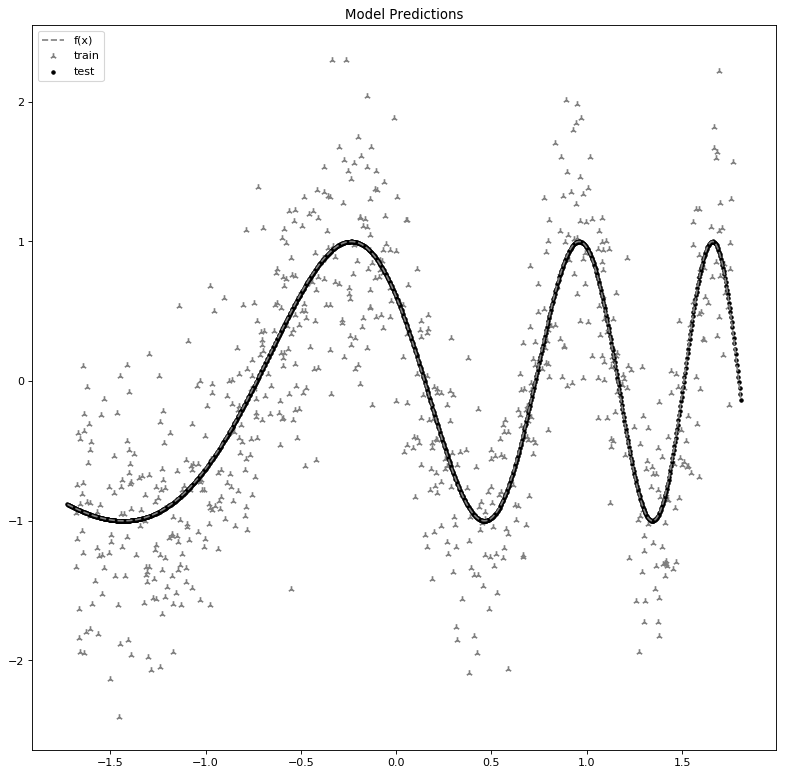

In [12]:
# Run Univariate Regression File #
#--------------------------------#
%run Data_Generator.ipynb
%run Univariate_Regression_Benchmark_Models.ipynb

# Visualize Predictions

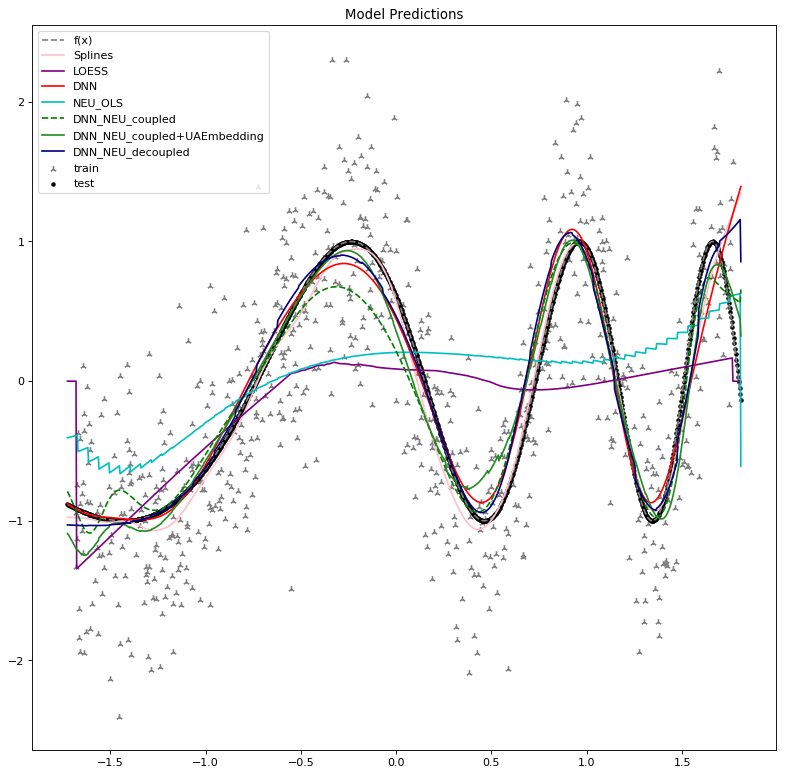

In [14]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot Non-Linar Benchmark(s): Classical
plt.plot(np.array(data_x_test).reshape(-1,),f_hat_smoothing_splines_test,color='pink',label='Splines')
plt.plot(np.array(data_x_test).reshape(-1,),LOESS_prediction_test,color='purple',label='LOESS')
# Plot Benchmark(s): DNNs
plt.plot(np.array(data_x_test).reshape(-1,),ffNN_y_hat_test, color = 'red', label='DNN')

#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-OLS
plt.plot(np.array(data_x_test).reshape(-1,),NEU_OLS_y_hat_test, color = 'c',label='NEU_OLS')
# plt.plot(np.array(data_x_test).reshape(-1,),OLS_y_hat_test, color = 'orange',label='NEU_OLS')
# # Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),NEU_ffNN_y_hat_test, linestyle="--", color = 'green',label='DNN_NEU_coupled')
plt.plot(np.array(data_x_test).reshape(-1,),NEU_ffNN_y_hat_test_w_proj, color = 'forestgreen',label='DNN_NEU_coupled+UAEmbedding')
plt.plot(np.array(data_x_test).reshape(-1,),NEU_ffNN_y_hat_test_Dcpld, color = 'navy',label='DNN_NEU_decoupled')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

 ---

## Performance Report

In [18]:
#--------------------#
# Classical Model(s) #
#--------------------#
# NEU-OLS Performance
print("OLS-Performance:")
# print(reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test))

# NEU-OLS Performance
print("NEU-OLS-Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

OLS-Performance:
NEU-OLS-Performance:
           train        test
MAE     0.676986    0.529508
MSE     0.691448    0.378327
MAPE  575.618643  413.414328


In [19]:
# Splines Performance
print("Splines-Performance:")
print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

# Loess Performance
print("LOESS Performance:")
print(reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test))

Splines-Performance:
           train       test
MAE     0.422409   0.104311
MSE     0.275531   0.033950
MAPE  413.935884  37.415892
LOESS Performance:
            train      test
MAE      0.647037  0.488546
MSE      0.637335  0.348689
MAPE  2687.159643       inf


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


In [20]:
#--------------#
# DNN Model(s) #
#--------------#
# ffNN Performance
print("ffNN-Performance:")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

# NEU-ffNN Performance
print("NEU-ffNN (Coupled) Performance:")
print(reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test))
print("NEU-ffNN (Coupled+UAEmbedding) Performance:")
print(reporter(NEU_ffNN_y_hat_train_w_proj,NEU_ffNN_y_hat_test_w_proj,data_y,data_y_test))
print("NEU-ffNN (Decoupled) Performance:")
print(reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test))

ffNN-Performance:
           train        test
MAE     0.465923    0.129972
MSE     0.329661    0.044019
MAPE  278.247217  183.481929
NEU-ffNN (Coupled) Performance:
           train       test
MAE     0.476682   0.154739
MSE     0.345858   0.038631
MAPE  185.608816  94.451387
NEU-ffNN (Coupled+UAEmbedding) Performance:
           train       test
MAE     0.470597   0.141940
MSE     0.334923   0.031996
MAPE  254.124501  95.544993
NEU-ffNN (Decoupled) Performance:
           train         test
MAE     0.464670     0.115012
MSE     0.328020     0.033627
MAPE  260.860729  1526.201380


#### The END

---